In [5]:
#basic operations
from typing import Union, Tuple, Optional
import os
from tqdm import tqdm
from functools import wraps

#data handling 
import segyio

#math core
import numpy as np
from numpy.random import RandomState

import pylops

import scipy
from scipy.sparse import csc_matrix, linalg
from scipy import signal
from scipy.optimize import minimize
from scipy.signal import butter, tukey, filtfilt

#visualization core
import matplotlib.pyplot as plt
import matplotlib.colors

In [40]:
def vectorize(func):
    """
    Decorator to make sure the inputs are arrays. We also add a dimension
    to theta to make the functions work in an 'outer product' way.

    Takes a reflectivity function requiring Vp, Vs, and RHOB for 2 rocks
    (upper and lower), plus incidence angle theta, plus kwargs. Returns
    that function with the arguments transformed to ndarrays.
    """
    @wraps(func)
    def wrapper(vp1, vs1, rho1, vp2, vs2, rho2, theta1=0, **kwargs):

        vp1 = np.asanyarray(vp1, dtype=float)
        vs1 = np.asanyarray(vs1, dtype=float) + 1e-12  # Prevent singular matrix.
        rho1 = np.asanyarray(rho1, dtype=float)
        vp2 = np.asanyarray(vp2, dtype=float)
        vs2 = np.asanyarray(vs2, dtype=float) + 1e-12  # Prevent singular matrix.
        rho2 = np.asanyarray(rho2, dtype=float)

        new_shape = [-1] + vp1.ndim * [1]
        theta1 = theta1.reshape(*new_shape)
        if (np.nan_to_num(theta1) > np.pi/2.).any():
            raise ValueError("Incidence angle theta1 must be less than 90 deg.")

        return func(vp1, vs1, rho1, vp2, vs2, rho2, theta1, **kwargs)
    return wrapper


def preprocess(func):
    """
    Decorator to preprocess arguments for the reflectivity equations.

    Takes a reflectivity function requiring Vp, Vs, and RHOB for 2 rocks
    (upper and lower), plus incidence angle theta, plus kwargs. Returns
    that function with some arguments transformed.
    """
    @wraps(func)
    def wrapper(vp1, vs1, rho1, vp2, vs2, rho2, theta1=0, **kwargs):

        # Interpret tuple for theta1 as a linspace.
        if isinstance(theta1, tuple):
            if len(theta1) == 2:
                start, stop = theta1
                theta1 = np.linspace(start, stop, num=stop+1)
            elif len(theta1) == 3:
                start, stop, step = theta1
                steps = (stop / step) + 1
                theta1 = np.linspace(start, stop, num=steps)
            else:
                raise TypeError("Expected 2 or 3 parameters for theta1 expressed as range.")

        # Convert theta1 to radians and complex numbers.
        theta1 = np.radians(theta1).astype(complex)

        return func(vp1, vs1, rho1, vp2, vs2, rho2, theta1, **kwargs)
    return wrapper

def zoeppritz(vp1, vs1, rho1, vp2, vs2, rho2, theta1=0):
    """
    Returns the PP reflection coefficients from the Zoeppritz
    scattering matrix. Wraps zoeppritz_element().

    Returns the complex reflectivity.

    Args:
        vp1 (float): The upper P-wave velocity.
        vs1 (float): The upper S-wave velocity.
        rho1 (float): The upper layer's density.
        vp2 (float): The lower P-wave velocity.
        vs2 (float): The lower S-wave velocity.
        rho2 (float): The lower layer's density.
        theta1 (ndarray): The incidence angle; float or 1D array length n.

    Returns:
        ndarray. Array length n of the exact Zoeppritz solution for the
            specified modes at the interface, at the incident angle theta1.
    """
    return zoeppritz_element(vp1, vs1, rho1, vp2, vs2, rho2, theta1, 'PdPu')


@preprocess
@vectorize
def zoeppritz_rpp(vp1, vs1, rho1, vp2, vs2, rho2, theta1=0):
    """
    Exact Zoeppritz from expression.

    This is useful because we can pass arrays to it, which we can't do to
    scattering_matrix().

    Dvorkin et al. (2014). Seismic Reflections of Rock Properties. Cambridge.

    Returns the complex reflectivity.

    Args:
        vp1 (ndarray): The upper P-wave velocity; float or 1D array length m.
        vs1 (ndarray): The upper S-wave velocity; float or 1D array length m.
        rho1 (ndarray): The upper layer's density; float or 1D array length m.
        vp2 (ndarray): The lower P-wave velocity; float or 1D array length m.
        vs2 (ndarray): The lower S-wave velocity; float or 1D array length m.
        rho2 (ndarray): The lower layer's density; float or 1D array length m.
        theta1 (ndarray): The incidence angle; float or 1D array length n.

    Returns:
        ndarray. The exact Zoeppritz solution for P-P reflectivity at the
            interface. Will be a float (for float inputs and one angle), a
            1 x n array (for float inputs and an array of angles), a 1 x m
            array (for float inputs and one angle), or an n x m array (for
            array inputs and an array of angles).
    """
    p = np.sin(theta1) / vp1  # Ray parameter
    theta2 = np.arcsin(p * vp2)
    phi1 = np.arcsin(p * vs1)  # Reflected S
    phi2 = np.arcsin(p * vs2)  # Transmitted S

    a = rho2 * (1 - 2 * np.sin(phi2)**2.) - rho1 * (1 - 2 * np.sin(phi1)**2.)
    b = rho2 * (1 - 2 * np.sin(phi2)**2.) + 2 * rho1 * np.sin(phi1)**2.
    c = rho1 * (1 - 2 * np.sin(phi1)**2.) + 2 * rho2 * np.sin(phi2)**2.
    d = 2 * (rho2 * vs2**2 - rho1 * vs1**2)

    E = (b * np.cos(theta1) / vp1) + (c * np.cos(theta2) / vp2)
    F = (b * np.cos(phi1) / vs1) + (c * np.cos(phi2) / vs2)
    G = a - d * np.cos(theta1)/vp1 * np.cos(phi2)/vs2
    H = a - d * np.cos(theta2)/vp2 * np.cos(phi1)/vs1

    D = E*F + G*H*p**2

    rpp = (1/D) * (F*(b*(np.cos(theta1)/vp1) - c*(np.cos(theta2)/vp2)) \
                   - H*p**2 * (a + d*(np.cos(theta1)/vp1)*(np.cos(phi2)/vs2)))

    return np.squeeze(rpp)
def zoeppritz(vp1, vs1, rho1, vp2, vs2, rho2, theta1=0):
    """
    Returns the PP reflection coefficients from the Zoeppritz
    scattering matrix. Wraps zoeppritz_element().

    Returns the complex reflectivity.

    Args:
        vp1 (float): The upper P-wave velocity.
        vs1 (float): The upper S-wave velocity.
        rho1 (float): The upper layer's density.
        vp2 (float): The lower P-wave velocity.
        vs2 (float): The lower S-wave velocity.
        rho2 (float): The lower layer's density.
        theta1 (ndarray): The incidence angle; float or 1D array length n.

    Returns:
        ndarray. Array length n of the exact Zoeppritz solution for the
            specified modes at the interface, at the incident angle theta1.
    """
    return zoeppritz_element(vp1, vs1, rho1, vp2, vs2, rho2, theta1, 'PdPu')


@preprocess
@vectorize
def zoeppritz_rpp(vp1, vs1, rho1, vp2, vs2, rho2, theta1=0):
    """
    Exact Zoeppritz from expression.

    This is useful because we can pass arrays to it, which we can't do to
    scattering_matrix().

    Dvorkin et al. (2014). Seismic Reflections of Rock Properties. Cambridge.

    Returns the complex reflectivity.

    Args:
        vp1 (ndarray): The upper P-wave velocity; float or 1D array length m.
        vs1 (ndarray): The upper S-wave velocity; float or 1D array length m.
        rho1 (ndarray): The upper layer's density; float or 1D array length m.
        vp2 (ndarray): The lower P-wave velocity; float or 1D array length m.
        vs2 (ndarray): The lower S-wave velocity; float or 1D array length m.
        rho2 (ndarray): The lower layer's density; float or 1D array length m.
        theta1 (ndarray): The incidence angle; float or 1D array length n.

    Returns:
        ndarray. The exact Zoeppritz solution for P-P reflectivity at the
            interface. Will be a float (for float inputs and one angle), a
            1 x n array (for float inputs and an array of angles), a 1 x m
            array (for float inputs and one angle), or an n x m array (for
            array inputs and an array of angles).
    """
    p = np.sin(theta1) / vp1  # Ray parameter
    theta2 = np.arcsin(p * vp2)
    phi1 = np.arcsin(p * vs1)  # Reflected S
    phi2 = np.arcsin(p * vs2)  # Transmitted S

    a = rho2 * (1 - 2 * np.sin(phi2)**2.) - rho1 * (1 - 2 * np.sin(phi1)**2.)
    b = rho2 * (1 - 2 * np.sin(phi2)**2.) + 2 * rho1 * np.sin(phi1)**2.
    c = rho1 * (1 - 2 * np.sin(phi1)**2.) + 2 * rho2 * np.sin(phi2)**2.
    d = 2 * (rho2 * vs2**2 - rho1 * vs1**2)

    E = (b * np.cos(theta1) / vp1) + (c * np.cos(theta2) / vp2)
    F = (b * np.cos(phi1) / vs1) + (c * np.cos(phi2) / vs2)
    G = a - d * np.cos(theta1)/vp1 * np.cos(phi2)/vs2
    H = a - d * np.cos(theta2)/vp2 * np.cos(phi1)/vs1

    D = E*F + G*H*p**2

    rpp = (1/D) * (F*(b*(np.cos(theta1)/vp1) - c*(np.cos(theta2)/vp2)) \
                   - H*p**2 * (a + d*(np.cos(theta1)/vp1)*(np.cos(phi2)/vs2)))

    return np.squeeze(rpp)
def zoeppritz(vp1, vs1, rho1, vp2, vs2, rho2, theta1=0):
    """
    Returns the PP reflection coefficients from the Zoeppritz
    scattering matrix. Wraps zoeppritz_element().

    Returns the complex reflectivity.

    Args:
        vp1 (float): The upper P-wave velocity.
        vs1 (float): The upper S-wave velocity.
        rho1 (float): The upper layer's density.
        vp2 (float): The lower P-wave velocity.
        vs2 (float): The lower S-wave velocity.
        rho2 (float): The lower layer's density.
        theta1 (ndarray): The incidence angle; float or 1D array length n.

    Returns:
        ndarray. Array length n of the exact Zoeppritz solution for the
            specified modes at the interface, at the incident angle theta1.
    """
    return zoeppritz_element(vp1, vs1, rho1, vp2, vs2, rho2, theta1, 'PdPu')


@preprocess
@vectorize
def zoeppritz_rpp(vp1, vs1, rho1, vp2, vs2, rho2, theta1=0):
    """
    Exact Zoeppritz from expression.

    This is useful because we can pass arrays to it, which we can't do to
    scattering_matrix().

    Dvorkin et al. (2014). Seismic Reflections of Rock Properties. Cambridge.

    Returns the complex reflectivity.

    Args:
        vp1 (ndarray): The upper P-wave velocity; float or 1D array length m.
        vs1 (ndarray): The upper S-wave velocity; float or 1D array length m.
        rho1 (ndarray): The upper layer's density; float or 1D array length m.
        vp2 (ndarray): The lower P-wave velocity; float or 1D array length m.
        vs2 (ndarray): The lower S-wave velocity; float or 1D array length m.
        rho2 (ndarray): The lower layer's density; float or 1D array length m.
        theta1 (ndarray): The incidence angle; float or 1D array length n.

    Returns:
        ndarray. The exact Zoeppritz solution for P-P reflectivity at the
            interface. Will be a float (for float inputs and one angle), a
            1 x n array (for float inputs and an array of angles), a 1 x m
            array (for float inputs and one angle), or an n x m array (for
            array inputs and an array of angles).
    """
    p = np.sin(theta1) / vp1  # Ray parameter
    theta2 = np.arcsin(p * vp2)
    phi1 = np.arcsin(p * vs1)  # Reflected S
    phi2 = np.arcsin(p * vs2)  # Transmitted S

    a = rho2 * (1 - 2 * np.sin(phi2)**2.) - rho1 * (1 - 2 * np.sin(phi1)**2.)
    b = rho2 * (1 - 2 * np.sin(phi2)**2.) + 2 * rho1 * np.sin(phi1)**2.
    c = rho1 * (1 - 2 * np.sin(phi1)**2.) + 2 * rho2 * np.sin(phi2)**2.
    d = 2 * (rho2 * vs2**2 - rho1 * vs1**2)

    E = (b * np.cos(theta1) / vp1) + (c * np.cos(theta2) / vp2)
    F = (b * np.cos(phi1) / vs1) + (c * np.cos(phi2) / vs2)
    G = a - d * np.cos(theta1)/vp1 * np.cos(phi2)/vs2
    H = a - d * np.cos(theta2)/vp2 * np.cos(phi1)/vs1

    D = E*F + G*H*p**2

    rpp = (1/D) * (F*(b*(np.cos(theta1)/vp1) - c*(np.cos(theta2)/vp2)) \
                   - H*p**2 * (a + d*(np.cos(theta1)/vp1)*(np.cos(phi2)/vs2)))

    return np.squeeze(rpp)
def zoeppritz(vp1, vs1, rho1, vp2, vs2, rho2, theta1=0):
    """
    Returns the PP reflection coefficients from the Zoeppritz
    scattering matrix. Wraps zoeppritz_element().

    Returns the complex reflectivity.

    Args:
        vp1 (float): The upper P-wave velocity.
        vs1 (float): The upper S-wave velocity.
        rho1 (float): The upper layer's density.
        vp2 (float): The lower P-wave velocity.
        vs2 (float): The lower S-wave velocity.
        rho2 (float): The lower layer's density.
        theta1 (ndarray): The incidence angle; float or 1D array length n.

    Returns:
        ndarray. Array length n of the exact Zoeppritz solution for the
            specified modes at the interface, at the incident angle theta1.
    """
    return zoeppritz_element(vp1, vs1, rho1, vp2, vs2, rho2, theta1, 'PdPu')


@preprocess
@vectorize
def zoeppritz_rpp(vp1, vs1, rho1, vp2, vs2, rho2, theta1=0):
    """
    Exact Zoeppritz from expression.

    This is useful because we can pass arrays to it, which we can't do to
    scattering_matrix().

    Dvorkin et al. (2014). Seismic Reflections of Rock Properties. Cambridge.

    Returns the complex reflectivity.

    Args:
        vp1 (ndarray): The upper P-wave velocity; float or 1D array length m.
        vs1 (ndarray): The upper S-wave velocity; float or 1D array length m.
        rho1 (ndarray): The upper layer's density; float or 1D array length m.
        vp2 (ndarray): The lower P-wave velocity; float or 1D array length m.
        vs2 (ndarray): The lower S-wave velocity; float or 1D array length m.
        rho2 (ndarray): The lower layer's density; float or 1D array length m.
        theta1 (ndarray): The incidence angle; float or 1D array length n.

    Returns:
        ndarray. The exact Zoeppritz solution for P-P reflectivity at the
            interface. Will be a float (for float inputs and one angle), a
            1 x n array (for float inputs and an array of angles), a 1 x m
            array (for float inputs and one angle), or an n x m array (for
            array inputs and an array of angles).
    """
    p = np.sin(theta1) / vp1  # Ray parameter
    theta2 = np.arcsin(p * vp2)
    phi1 = np.arcsin(p * vs1)  # Reflected S
    phi2 = np.arcsin(p * vs2)  # Transmitted S

    a = rho2 * (1 - 2 * np.sin(phi2)**2.) - rho1 * (1 - 2 * np.sin(phi1)**2.)
    b = rho2 * (1 - 2 * np.sin(phi2)**2.) + 2 * rho1 * np.sin(phi1)**2.
    c = rho1 * (1 - 2 * np.sin(phi1)**2.) + 2 * rho2 * np.sin(phi2)**2.
    d = 2 * (rho2 * vs2**2 - rho1 * vs1**2)

    E = (b * np.cos(theta1) / vp1) + (c * np.cos(theta2) / vp2)
    F = (b * np.cos(phi1) / vs1) + (c * np.cos(phi2) / vs2)
    G = a - d * np.cos(theta1)/vp1 * np.cos(phi2)/vs2
    H = a - d * np.cos(theta2)/vp2 * np.cos(phi1)/vs1

    D = E*F + G*H*p**2

    rpp = (1/D) * (F*(b*(np.cos(theta1)/vp1) - c*(np.cos(theta2)/vp2)) \
                   - H*p**2 * (a + d*(np.cos(theta1)/vp1)*(np.cos(phi2)/vs2)))

    return np.squeeze(rpp)


def reflectivity(vp, vs, rho, theta=0, method='zoeppritz_rpp', axis=0, mode='same'):
    """
    Offset reflectivity, given Vp, Vs, rho, and offset.

    For acoustic reflectivity, use `acoustic_reflectivity()`.

    Computes 'upper' and 'lower' intervals from the three provided arrays,
    then passes the result to the specified method to compute reflection
    coefficients.

    For acoustic reflectivity, either use the `acoustic_reflectivity()`
    function, or call `reflectivity()` passing any log as Vs, e.g. just give
    the Vp log twice (it won't be used anyway):

        reflectivity(vp, vp, rho)

    For anisotropic reflectivity, use either `anisotropy.blangy()` or
    `anisotropy.ruger()`.

    Args:
        vp (ndarray): The P-wave velocity; float or 1D array length m.
        vs (ndarray): The S-wave velocity; float or 1D array length m.
        rho (ndarray): The density; float or 1D array length m.
        theta (ndarray): The incidence angle; float or 1D array length n.
        axis (int): The dimension along which to compute the reflectivity.
        mode (str): 'same' means the output will be the same shape. 'valid'
            means that only strictly valid reflectivities are computed so
            the result will be one sample shorted in the `axis` dimension.
        method (str): The reflectivity equation to use; one of:

            - 'scattering_matrix': scattering_matrix
            - 'zoeppritz_element': zoeppritz_element
            - 'zoeppritz': zoeppritz
            - 'zoeppritz_rpp': zoeppritz_rpp
            - 'akirichards': akirichards
            - 'akirichards_alt': akirichards_alt
            - 'fatti': fatti
            - 'shuey': shuey
            - 'bortfeld': bortfeld
            - 'hilterman': hilterman

        Notes:

            - scattering_matrix gives the full solution
            - zoeppritz_element gives a single element which you specify
            - zoeppritz returns RPP element only; use zoeppritz_rpp instead
            - zoeppritz_rpp is faster than zoeppritz or zoeppritz_element
            - You can also pass a function with the same API as these built-in
                functions.

    Returns:
        ndarray. The result of running the specified method on the inputs.
            Will be a float (for float inputs and one angle), a 1 x n array
            (for float inputs and an array of angles), a 1 x m-1 array (for
            float inputs and one angle), or an m-1 x n array (for array inputs
            and an array of angles).
    """
    methods = {
        'scattering_matrix': scattering_matrix,
        'zoeppritz_rpp': zoeppritz_rpp,

    }
    func = methods.get(method.casefold(), method)
    
    if axis < 0:
        axis = vp.ndim + axis

    if axis > 0:
        vp_  = np.moveaxis(np.asanyarray(vp, dtype=float), axis, 0)
        vs_  = np.moveaxis(np.asanyarray(vs, dtype=float), axis, 0)
        rho_ = np.moveaxis(np.asanyarray(rho, dtype=float), axis, 0)
    else:
        vp_, vs_, rho_ = vp, vs, rho

    if mode == 'same':
        pad_width = [(0, 1)] + (vp.ndim - 1) * [(0, 0)]
        vp_ = np.pad(vp_, pad_width=pad_width, mode='edge')
        vs_ = np.pad(vs_, pad_width=pad_width, mode='edge')
        rho_ = np.pad(rho_, pad_width=pad_width, mode='edge')

    rc = func(vp_[:-1], vs_[:-1], rho_[:-1], vp_[1:], vs_[1:], rho_[1:], theta)

    if axis > 0:
        return np.moveaxis(rc, 0, axis)
    else:
        return np.squeeze(rc)
    
@preprocess
@vectorize
def scattering_matrix(vp1, vs1, rho1, vp2, vs2, rho2, theta1=0):
    """
    Full Zoeppritz solution, considered the definitive solution.
    Calculates the angle dependent p-wave reflectivity of an interface
    between two mediums.

    Originally written by: Wes Hamlyn, vectorized by Agile.

    Returns the complex reflectivity.

    Args:
        vp1 (float): The upper P-wave velocity.
        vs1 (float): The upper S-wave velocity.
        rho1 (float): The upper layer's density.
        vp2 (float): The lower P-wave velocity.
        vs2 (float): The lower S-wave velocity.
        rho2 (float): The lower layer's density.
        theta1 (ndarray): The incidence angle; float or 1D array length n.

    Returns:
        ndarray. The exact Zoeppritz solution for all modes at the interface.
            A 4x4 array representing the scattering matrix at the incident
            angle theta1.
    """
    theta1 *= np.ones_like(vp1)
    p = np.sin(theta1) / vp1  # Ray parameter.
    theta2 = np.arcsin(p * vp2)  # Trans. angle of P-wave.
    phi1 = np.arcsin(p * vs1)    # Refl. angle of converted S-wave.
    phi2 = np.arcsin(p * vs2)    # Trans. angle of converted S-wave.

    # Matrix form of Zoeppritz equations... M & N are matrices.
    M = np.array([[-np.sin(theta1), -np.cos(phi1), np.sin(theta2), np.cos(phi2)],
                  [np.cos(theta1), -np.sin(phi1), np.cos(theta2), -np.sin(phi2)],
                  [2 * rho1 * vs1 * np.sin(phi1) * np.cos(theta1),
                   rho1 * vs1 * (1 - 2 * np.sin(phi1) ** 2),
                   2 * rho2 * vs2 * np.sin(phi2) * np.cos(theta2),
                   rho2 * vs2 * (1 - 2 * np.sin(phi2) ** 2)],
                  [-rho1 * vp1 * (1 - 2 * np.sin(phi1) ** 2),
                   rho1 * vs1 * np.sin(2 * phi1),
                   rho2 * vp2 * (1 - 2 * np.sin(phi2) ** 2),
                   -rho2 * vs2 * np.sin(2 * phi2)]])

    N = np.array([[np.sin(theta1), np.cos(phi1), -np.sin(theta2), -np.cos(phi2)],
                  [np.cos(theta1), -np.sin(phi1), np.cos(theta2), -np.sin(phi2)],
                  [2 * rho1 * vs1 * np.sin(phi1) * np.cos(theta1),
                   rho1 * vs1 * (1 - 2 * np.sin(phi1) ** 2),
                   2 * rho2 * vs2 * np.sin(phi2) * np.cos(theta2),
                   rho2 * vs2 * (1 - 2 * np.sin(phi2) ** 2)],
                  [rho1 * vp1 * (1 - 2 * np.sin(phi1) ** 2),
                   -rho1 * vs1 * np.sin(2 * phi1),
                   - rho2 * vp2 * (1 - 2 * np.sin(phi2) ** 2),
                   rho2 * vs2 * np.sin(2 * phi2)]])

    M_ = np.moveaxis(np.squeeze(M), [0, 1], [-2, -1])
    A = np.linalg.inv(M_)
    N_ = np.moveaxis(np.squeeze(N), [0, 1], [-2, -1])
    Z_ = np.matmul(A, N_)

    return np.transpose(Z_, axes=list(range(Z_.ndim - 2)) + [-1, -2])


In [7]:
def butter_lowpass_filter(data, cutoff, fs, order):
    """
    Lowpass filter
    fs - sample rate (шаг дискретизации), Hz
    cutoff - desired cutoff frequency of the filter (желаемая частота среза фильтра), Hz
    order - sin wave can be approx represented as quadratic
    """
    normal_cutoff = 2*cutoff / fs
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

In [14]:
rs = RandomState(42)

nt = 500 #the length of traces

vp, vs, rhob = np.zeros(nt), np.zeros(nt), np.zeros(nt)

thickness = 80
global_variations_amplitude = 300
local_variations_amplitude = 250
trend_slope = 3
vp_trend_intercept = 4000
vs_trend_intercept = 2000

vp_low_frequency_trend = trend_slope*np.arange(nt) + vp_trend_intercept
vs_low_frequency_trend = trend_slope*np.arange(nt) + vs_trend_intercept

for i in range(thickness, nt):
    if not i%thickness:
        vp[i-thickness: i] = rs.randint(-global_variations_amplitude, global_variations_amplitude)
        vs[i-thickness: i] = rs.randint(-global_variations_amplitude+100, global_variations_amplitude-100) 
        rhob[i-thickness: i] = rs.randint(-global_variations_amplitude+100, global_variations_amplitude-100) 
        
vp += rs.normal(loc = 0.00, scale = local_variations_amplitude, size = (nt))
vs += rs.normal(loc = 0.00, scale = local_variations_amplitude-50, size = (nt))
rhob += rs.normal(loc = 0.00, scale = local_variations_amplitude-50, size = (nt))
vp += vp_low_frequency_trend
vs += vs_low_frequency_trend
rhob += vs_low_frequency_trend

rhob /= 1e3
 
vp_smoothed = scipy.ndimage.gaussian_filter(vp, 2)
vs_smoothed = scipy.ndimage.gaussian_filter(vs, 2)
rhob_smoothed = scipy.ndimage.gaussian_filter(rhob, 2)


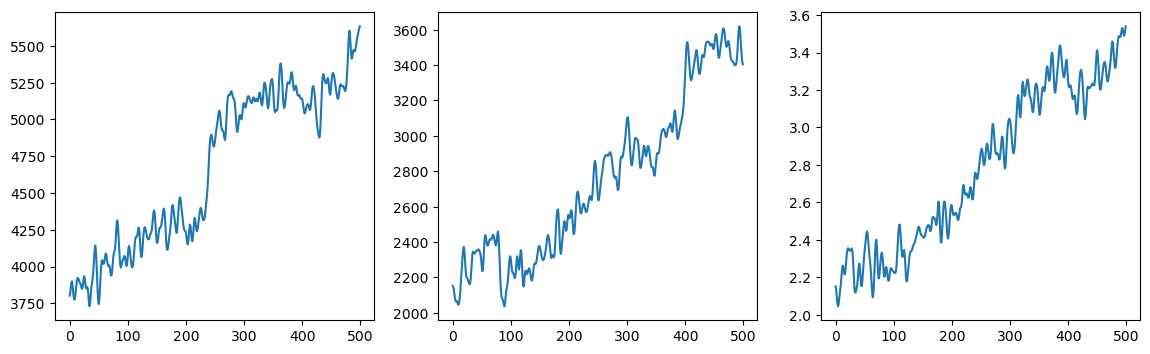

In [47]:
plt.figure(figsize = (14, 4))
plt.subplot(131)
plt.plot(vp_smoothed)

plt.subplot(132)
plt.plot(vs_smoothed)

plt.subplot(133)
plt.plot(rhob_smoothed)

Text(0.5, 1.0, 'Zoeppritz equation modelled traces')

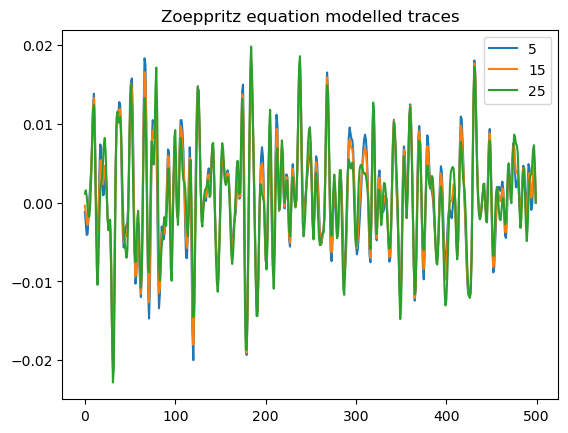

In [42]:
theta = [5, 15, 25]
for i in range(3):
    plt.plot(reflectivity(vp_smoothed, vs_smoothed, rhob_smoothed, method = "zoeppritz_rpp", theta = theta)[i].real, label = "%d" % theta[i])

plt.legend()

plt.title("Zoeppritz equation modelled traces")